# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [425]:
# Load the libraries as required.
import os

# Standard libraries
import pandas as pd
import numpy as np
import pickle

# Load environment variables
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_validate,ParameterGrid, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, r2_score

In [428]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [429]:
fires_dt.head()

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [430]:
X = fires_dt.drop(columns = ['area'])
Y = fires_dt['area'] 

In [431]:
X.info(), Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
dtypes: float64(7), int64(3), object(2)
memory usage: 48.6+ KB
<class 'pandas.core.series.Series'>
RangeIndex: 517 entries, 0 to 516
Series name: area
Non-Null Count  Dtype  
--------------  -----  
517 non-null    float64
dtypes: float64(1)
memory usage: 4.2 KB


(None, None)

In [ ]:
X_train, X_test, Y_train,  Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [553]:
# Preproc 1 Final version

# Select only numeric features for scaling
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
X_num = X[numeric_features]

cat_features = X.select_dtypes(include=['object']).columns
X_cat = X[cat_features]

num_cols = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']

pipe_num_simple = Pipeline([
    ('standardizer', StandardScaler())

])


preproc1= ColumnTransformer(transformers=[
    ('numeric_simple', pipe_num_simple, X_num.columns.values),
    ('cat_transform', OneHotEncoder(handle_unknown='ignore'), ['month','day']),
], remainder='passthrough')


### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [554]:
# Preproc 2

# Select only numeric features for scaling
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
X_num = X[numeric_features]

cat_features = X.select_dtypes(include=['object']).columns
X_cat = X[cat_features]

num_cols = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']

pipe_num_simple = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('standardizer', StandardScaler())

])


preproc2= ColumnTransformer(transformers=[
    ('numeric_simple', pipe_num_simple, X_num.columns.values),
    ('cat_transform', OneHotEncoder(handle_unknown='ignore'), ['month','day']),
], remainder='passthrough')

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [555]:
# Pipeline A = preproc1 + baseline
pipeA = Pipeline(
    [
        ('preprocessing', preproc1), 
        ('regressor', KNeighborsRegressor())
    ]
)
pipeA

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_simple',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler())]),
                                                  array(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
       'wind', 'rain'], dtype=object)),
                                                 ('cat_transform',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', KNeighborsRegressor())])

In [556]:
# Pipeline B = preproc2 + baseline
pipeB = Pipeline(
    [
        ('preprocessing', preproc2), 
        ('regressor', KNeighborsRegressor())
    ]
)
pipeB

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_simple',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardizer',
                                                                   StandardScaler())]),
                                                  array(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
       'wind', 'rain'], dtype=object)),
                                                 ('cat_transform',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', KNeighborsRegressor())])

In [557]:
# Pipeline C = preproc1 + advanced model
pipeC = Pipeline(
    [
        ('preprocessing', preproc1), 
        ('regressor', RandomForestRegressor())
    ]
)
pipeC

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_simple',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler())]),
                                                  array(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
       'wind', 'rain'], dtype=object)),
                                                 ('cat_transform',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

In [558]:
# Pipeline D = preproc2 + advanced model
pipeD = Pipeline(
    [
        ('preprocessing', preproc2), 
        ('regressor', RandomForestRegressor())
    ]
)
pipeD

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_simple',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardizer',
                                                                   StandardScaler())]),
                                                  array(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
       'wind', 'rain'], dtype=object)),
                                                 ('cat_transform',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [559]:
# Parameter Grid for Pipeline A and B using Non-Linear Model: KNeighborsRegressor
param_grid_A_B = {
    'regressor__n_neighbors': [3, 5, 7, 11, 15, 21],
    'regressor__metric': ['euclidean', 'manhattan'],
    'regressor__weights': ['uniform', 'distance'],
    }

In [561]:
# Parameter Grid for Pipeline C and D using Advanced Model: RandomForestRegressor
param_grid_C_D = {
# Number of trees (more is usually better, but slower)
    'regressor__n_estimators': [100, 300, 500],
    
    # Depth: Forest fire data can be sparse; start shallow to avoid overfitting
    'regressor__max_depth': [None, 5, 10, 15],
    
    # Crucial for small datasets: prevents splits that only capture 1-2 fires
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    
    # Feature sub-sampling: helps the model focus on different weather/spatial factors
    'regressor__max_features': ['sqrt', 'log2', None]
    }

In [562]:
scoring_KNeighborsRegressor = ['r2','neg_mean_squared_error','neg_mean_absolute_error','neg_mean_absolute_percentage_error']

In [563]:
# GridSearch For Pipeline A
grid_cv_A = GridSearchCV(
    estimator=pipeA, 
    param_grid=param_grid_A_B, 
    scoring = scoring_KNeighborsRegressor, 
    cv = 5,
    refit = "r2")
grid_cv_A.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric_simple',
                                                                         Pipeline(steps=[('standardizer',
                                                                                          StandardScaler())]),
                                                                         array(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
       'wind', 'rain'], dtype=object)),
                                                                        ('cat_transform',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', KNeighborsRegressor())]),
             param_grid={'regressor__metric': ['euclidean', 'manhattan'],
                         'regressor__n_neighbors': [3, 5, 7, 11, 15, 21],
                         'regressor__weights': ['uniform', 'distance']},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

In [564]:
# GridSearch For Pipeline B
grid_cv_B = GridSearchCV(
    estimator=pipeB, 
    param_grid=param_grid_A_B, 
    scoring = scoring_KNeighborsRegressor, 
    cv = 5,
    refit = "r2")
grid_cv_B.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric_simple',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardizer',
                                                                                          StandardScaler())]),
                                                                         array(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
       'wind', 'rain'], dtype=object)),
                                                                        ('cat_transform',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', KNeighborsRegressor())]),
             param_grid={'regressor__metric': ['euclidean', 'manhattan'],
                         'regressor__n_neighbors': [3, 5, 7, 11, 15, 21],
                         'regressor__weights': ['uniform', 'distance']},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

In [565]:
# GridSearch For Pipeline C
grid_cv_C = GridSearchCV(
    estimator=pipeC, 
    param_grid=param_grid_C_D, 
    scoring = 'neg_mean_squared_error', 
    cv = 5,
    n_jobs=-1)
grid_cv_C.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric_simple',
                                                                         Pipeline(steps=[('standardizer',
                                                                                          StandardScaler())]),
                                                                         array(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
       'wind', 'rain'], dtype=object)),
                                                                        ('cat_transform',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 5, 10, 15],
                         'regressor__max_features': ['sqrt', 'log2', None],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [100, 300, 500]},
             scoring='neg_mean_squared_error')

In [566]:
# GridSearch For Pipeline D
grid_cv_D = GridSearchCV(
    estimator=pipeD, 
    param_grid=param_grid_C_D, 
    scoring = 'neg_mean_squared_error', 
    cv = 5,
    n_jobs=-1)
grid_cv_D.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric_simple',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardizer',
                                                                                          StandardScaler())]),
                                                                         array(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
       'wind', 'rain'], dtype=object)),
                                                                        ('cat_transform',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 5, 10, 15],
                         'regressor__max_features': ['sqrt', 'log2', None],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [100, 300, 500]},
             scoring='neg_mean_squared_error')

In [567]:
KNeighborsRegressor_perf_metrics = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time','param_regressor__n_neighbors',
                                    'params', 'std_test_r2', 'rank_test_r2', 'mean_test_neg_mean_squared_error', 
       'rank_test_neg_mean_squared_error','std_test_neg_mean_absolute_error','rank_test_neg_mean_absolute_error']

In [568]:
RandomForestRegressor_perf_metrics = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time','param_regressor__max_depth', 
                                      'param_regressor__max_features','param_regressor__min_samples_leaf','param_regressor__n_estimators',
                                      'params','std_test_score', 'rank_test_score']

In [569]:
# Storing GRIDCV Results for Pipeline A, B, C and D
res_A = pd.DataFrame(grid_cv_A.cv_results_)
res_B = pd.DataFrame(grid_cv_B.cv_results_)
res_C = pd.DataFrame(grid_cv_C.cv_results_)
res_D = pd.DataFrame(grid_cv_D.cv_results_)


In [570]:
res_A[KNeighborsRegressor_perf_metrics].sort_values('rank_test_r2')
# res_A[KNeighborsRegressor_perf_metrics].sort_values('rank_test_neg_mean_squared_error')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__n_neighbors,params,std_test_r2,rank_test_r2,mean_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
10,0.001440,0.000044,0.001991,0.000113,21,"{'regressor__metric': 'euclidean', 'regressor_...",0.295976,1,-2094.035825,1,3.746613,2
11,0.001438,0.000028,0.002798,0.000380,21,"{'regressor__metric': 'euclidean', 'regressor_...",0.307258,2,-2111.883450,3,3.646904,1
8,0.001496,0.000050,0.002120,0.000303,15,"{'regressor__metric': 'euclidean', 'regressor_...",0.460777,3,-2108.812875,2,3.366404,4
9,0.001483,0.000070,0.002818,0.000307,15,"{'regressor__metric': 'euclidean', 'regressor_...",0.464396,4,-2138.597740,5,3.312584,3
22,0.001460,0.000080,0.002126,0.000448,21,"{'regressor__metric': 'manhattan', 'regressor_...",0.416242,5,-2163.607637,6,3.435965,11
23,0.001500,0.000084,0.002773,0.000452,21,"{'regressor__metric': 'manhattan', 'regressor_...",0.412780,6,-2185.767972,8,3.456622,7
20,0.001411,0.000022,0.001828,0.000031,15,"{'regressor__metric': 'manhattan', 'regressor_...",0.440291,7,-2238.349333,9,4.247264,12
6,0.001898,0.000577,0.002551,0.000420,11,"{'regressor__metric': 'euclidean', 'regressor_...",0.644332,8,-2132.229682,4,3.510941,6
21,0.001423,0.000027,0.002603,0.000606,15,"{'regressor__metric': 'manhattan', 'regressor_...",0.442910,9,-2274.480130,10,4.073406,10
7,0.002701,0.001593,0.002827,0.000279,11,"{'regressor__metric': 'euclidean', 'regressor_...",0.653440,10,-2183.993734,7,3.505691,5


In [571]:
grid_cv_A.best_params_  


{'regressor__metric': 'euclidean',
 'regressor__n_neighbors': 21,
 'regressor__weights': 'uniform'}

In [572]:
grid_cv_A.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_simple',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler())]),
                                                  array(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
       'wind', 'rain'], dtype=object)),
                                                 ('cat_transform',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor',
                 KNeighborsRegressor(metric='euclidean', n_neighbors=21))])

In [573]:
res_B[KNeighborsRegressor_perf_metrics].sort_values('rank_test_r2')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__n_neighbors,params,std_test_r2,rank_test_r2,mean_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
10,0.001946,0.000244,0.002241,0.000112,21,"{'regressor__metric': 'euclidean', 'regressor_...",0.295976,1,-2094.035825,1,3.746613,2
11,0.001995,0.000301,0.002869,0.000550,21,"{'regressor__metric': 'euclidean', 'regressor_...",0.307258,2,-2111.883450,3,3.646904,1
8,0.001836,0.000054,0.002435,0.000579,15,"{'regressor__metric': 'euclidean', 'regressor_...",0.460777,3,-2108.812875,2,3.366404,4
9,0.001803,0.000021,0.003064,0.000570,15,"{'regressor__metric': 'euclidean', 'regressor_...",0.464396,4,-2138.597740,5,3.312584,3
22,0.001794,0.000024,0.002385,0.000434,21,"{'regressor__metric': 'manhattan', 'regressor_...",0.416242,5,-2163.607637,6,3.435965,11
23,0.001843,0.000080,0.002636,0.000524,21,"{'regressor__metric': 'manhattan', 'regressor_...",0.412780,6,-2185.767972,8,3.456622,7
20,0.001793,0.000033,0.002347,0.000448,15,"{'regressor__metric': 'manhattan', 'regressor_...",0.440291,7,-2238.349333,9,4.247264,12
6,0.002313,0.000932,0.002396,0.000449,11,"{'regressor__metric': 'euclidean', 'regressor_...",0.644332,8,-2132.229682,4,3.510941,6
21,0.001788,0.000013,0.002712,0.000611,15,"{'regressor__metric': 'manhattan', 'regressor_...",0.442910,9,-2274.480130,10,4.073406,10
7,0.001816,0.000082,0.003005,0.000798,11,"{'regressor__metric': 'euclidean', 'regressor_...",0.653440,10,-2183.993734,7,3.505691,5


In [574]:
grid_cv_B.best_params_

{'regressor__metric': 'euclidean',
 'regressor__n_neighbors': 21,
 'regressor__weights': 'uniform'}

In [575]:
grid_cv_B.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_simple',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardizer',
                                                                   StandardScaler())]),
                                                  array(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
       'wind', 'rain'], dtype=object)),
                                                 ('cat_transform',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor',
                 KNeighborsRegressor(metric='euclidean', n_neighbors=21))])

In [576]:
res_C[RandomForestRegressor_perf_metrics].sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__max_features,param_regressor__min_samples_leaf,param_regressor__n_estimators,params,std_test_score,rank_test_score
210,0.049342,0.004252,0.005590,0.001647,10,log2,4,100,"{'regressor__max_depth': 10, 'regressor__max_f...",2564.415719,1
134,0.228477,0.014239,0.016908,0.004083,5,log2,4,500,"{'regressor__max_depth': 5, 'regressor__max_fe...",2580.754911,2
132,0.050030,0.005762,0.005495,0.001886,5,log2,4,100,"{'regressor__max_depth': 5, 'regressor__max_fe...",2563.604479,3
133,0.138508,0.013623,0.010448,0.002680,5,log2,4,300,"{'regressor__max_depth': 5, 'regressor__max_fe...",2572.446517,4
213,0.051170,0.002774,0.005860,0.002037,10,log2,4,100,"{'regressor__max_depth': 10, 'regressor__max_f...",2548.688605,5
...,...,...,...,...,...,...,...,...,...,...,...
54,0.146513,0.011728,0.007336,0.001145,None,None,1,100,"{'regressor__max_depth': None, 'regressor__max...",2491.112350,320
298,0.457389,0.029201,0.013345,0.002004,15,None,1,300,"{'regressor__max_depth': 15, 'regressor__max_f...",2505.667006,321
55,0.408335,0.018695,0.010390,0.002013,None,None,1,300,"{'regressor__max_depth': None, 'regressor__max...",2489.486026,322
216,0.121531,0.023563,0.004275,0.000599,10,None,1,100,"{'regressor__max_depth': 10, 'regressor__max_f...",2456.322897,323


In [577]:
grid_cv_C.best_params_

{'regressor__max_depth': 10,
 'regressor__max_features': 'log2',
 'regressor__min_samples_leaf': 4,
 'regressor__min_samples_split': 5,
 'regressor__n_estimators': 100}

In [578]:
grid_cv_C.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_simple',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler())]),
                                                  array(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
       'wind', 'rain'], dtype=object)),
                                                 ('cat_transform',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, max_features='log2',
                                       min_samples_leaf=4,
                                       min_samples_split=5))])

In [579]:
res_D[RandomForestRegressor_perf_metrics].sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__max_features,param_regressor__min_samples_leaf,param_regressor__n_estimators,params,std_test_score,rank_test_score
105,0.053568,0.004779,0.004862,0.001521,5,sqrt,4,100,"{'regressor__max_depth': 5, 'regressor__max_fe...",2578.682986,1
127,0.156090,0.010787,0.009949,0.002007,5,log2,4,300,"{'regressor__max_depth': 5, 'regressor__max_fe...",2567.351665,2
134,0.243688,0.017454,0.020254,0.003468,5,log2,4,500,"{'regressor__max_depth': 5, 'regressor__max_fe...",2568.004748,3
295,0.205315,0.027709,0.019286,0.007003,15,log2,4,300,"{'regressor__max_depth': 15, 'regressor__max_f...",2551.427797,4
210,0.055284,0.003734,0.006140,0.001791,10,log2,4,100,"{'regressor__max_depth': 10, 'regressor__max_f...",2556.007271,5
...,...,...,...,...,...,...,...,...,...,...,...
55,0.442493,0.010047,0.010532,0.001753,None,None,1,300,"{'regressor__max_depth': None, 'regressor__max...",2515.718325,320
298,0.516333,0.070776,0.017376,0.005566,15,None,1,300,"{'regressor__max_depth': 15, 'regressor__max_f...",2490.939632,321
216,0.138336,0.007411,0.005523,0.001715,10,None,1,100,"{'regressor__max_depth': 10, 'regressor__max_f...",2512.096272,322
54,0.175376,0.036106,0.006514,0.002163,None,None,1,100,"{'regressor__max_depth': None, 'regressor__max...",2520.721567,323


In [580]:
grid_cv_D.best_params_

{'regressor__max_depth': 5,
 'regressor__max_features': 'sqrt',
 'regressor__min_samples_leaf': 4,
 'regressor__min_samples_split': 10,
 'regressor__n_estimators': 100}

In [581]:
grid_cv_D.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_simple',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardizer',
                                                                   StandardScaler())]),
                                                  array(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
       'wind', 'rain'], dtype=object)),
                                                 ('cat_transform',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=5, max_features='sqrt',
                                       min_samples_leaf=4,
                                       min_samples_split=10))])

# Evaluate

+ Which model has the best performance?

Pipeline D with RandomForest Regressor is the best model since it has lowest RMSE and good R2 Score.

In [585]:
# Evaluating Model scores
pipeA_knn_pred = grid_cv_A.predict(X_test)
pipeB_knn_pred = grid_cv_B.predict(X_test)
pipeC_rf_pred = grid_cv_C.predict(X_test)
pipeD_rf_pred = grid_cv_D.predict(X_test)

print(f"Pipeline A: kNN RMSE: {np.sqrt(mean_squared_error(Y_test, pipeA_knn_pred))} R2_Score: {r2_score(Y_test, pipeA_knn_pred)}")
print(f"Pipeline B: kNN RMSE: {np.sqrt(mean_squared_error(Y_test, pipeB_knn_pred))} R2_Score: {r2_score(Y_test, pipeB_knn_pred)}")
print(f"Pipeline C: RF RMSE: {np.sqrt(mean_squared_error(Y_test, pipeC_rf_pred))} R2_Score: {r2_score(Y_test, pipeC_rf_pred)}")
print(f"Pipeline D: RF RMSE: {np.sqrt(mean_squared_error(Y_test, pipeD_rf_pred))} R2_Score: {r2_score(Y_test, pipeD_rf_pred)}  Best Model Score")
print("Best Model Score Pipeline D")


Pipeline A: kNN RMSE: 108.70347054486827 R2_Score: -0.0024332343574016146
Pipeline B: kNN RMSE: 108.70347054486827 R2_Score: -0.0024332343574016146
Pipeline C: RF RMSE: 108.17898869286516 R2_Score: 0.007216681608254394
Pipeline D: RF RMSE: 107.9014238088123 R2_Score: 0.012304698657457425  Best Model Score
Best Model Score Pipeline D


# Export

+ Save the best performing model to a pickle file.

In [ ]:
# Exported Best performing model as pickle file for later use

os.makedirs("./models", exist_ok=True)
with open('./models/Forestfire_assignment_2.pkl', 'wb') as f:
    pickle.dump(grid_cv_D.best_estimator_, f)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [587]:
import pickle
with open('./models/Forestfire_assignment_2.pkl', 'rb') as f:
    pipe = pickle.load(f)

In [613]:
pipe.fit(X_train, Y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_simple',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardizer',
                                                                   StandardScaler())]),
                                                  array(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
       'wind', 'rain'], dtype=object)),
                                                 ('cat_transform',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=5, max_features='sqrt',
                                       min_samples_leaf=4,
                                       min_samples_split=10))])

In [ ]:
import shap
data_transform = pipe.named_steps['preprocessing'].transform(X_test)
explainer = shap.TreeExplainer(
    pipe.named_steps['regressor'], 
    data_transform,
    feature_names = pipe.named_steps['preprocessing'].get_feature_names_out())
shap_values = explainer(data_transform,check_additivity=False)

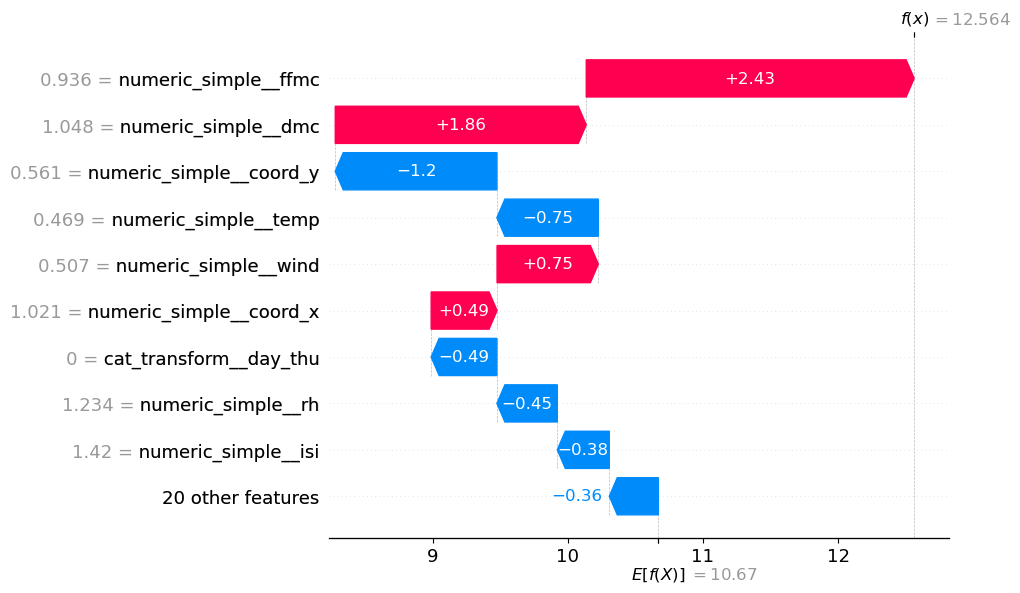

In [645]:
shap.plots.waterfall(shap_values[1])

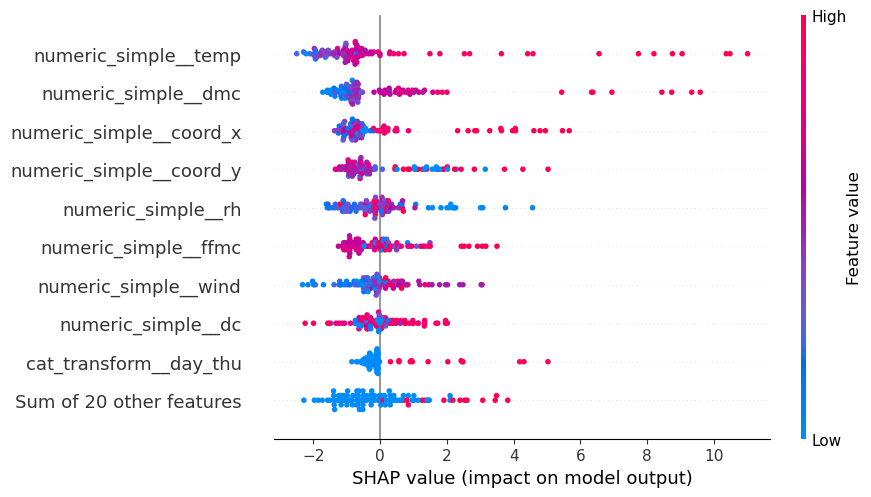

In [640]:
shap.plots.beeswarm(shap_values)

In [647]:
from sklearn.inspection import permutation_importance

pi_res = permutation_importance(
    pipe, X_test, Y_test, 
    n_repeats=30, 
    scoring = "neg_root_mean_squared_error")

In [649]:
importances_dt = pd.DataFrame(pi_res.importances).T
importances_dt.columns = X_test.columns

In [650]:
importances_dt

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain
0,-0.078722,0.008806,0.223108,0.174699,0.185010,0.256015,0.092246,0.034227,-0.299045,-0.242706,0.008474,0.0
1,-0.601551,-0.121470,0.197519,0.179886,0.057091,0.295468,0.076691,0.072168,-0.281790,-0.176156,-0.161197,0.0
2,-0.264646,-0.020964,0.030494,0.202073,-0.530260,0.254286,0.090347,0.192548,-0.330542,-0.307442,0.060095,0.0
3,-0.155491,-0.072545,-0.010650,0.178904,-0.020087,0.078088,0.398870,0.143408,-0.333520,-0.120127,-0.033269,0.0
4,-0.222034,0.013895,-0.043081,0.004127,0.135423,-0.052273,0.383333,0.086807,0.019034,-0.029840,0.056038,0.0
5,-0.014101,-0.015991,-0.012283,-0.047245,0.000690,-0.160549,0.032340,-0.001920,0.154846,-0.067461,0.141826,0.0
6,-0.161829,-0.007099,0.015163,0.073011,-0.533505,0.023541,0.139818,0.230834,0.004268,0.029425,0.052574,0.0
7,-0.109258,-0.081477,0.062024,0.088074,-0.010856,0.073679,0.279765,0.196276,-0.101013,-0.056292,-0.109091,0.0
8,-0.621814,-0.004339,0.219957,0.082781,0.022376,0.244311,0.148112,0.173087,-0.113393,-0.023574,0.077495,0.0
9,-0.143003,-0.007362,0.050349,0.058209,-0.399504,-0.071133,0.137118,0.193600,-0.018762,-0.236412,-0.043955,0.0


/var/folders/nc/zf3gffqx2rs30wf0h2k6d9gr0000gn/T/ipykernel_99522/2910106254.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(importances_dt, vert = False,  labels = importances_dt.columns)


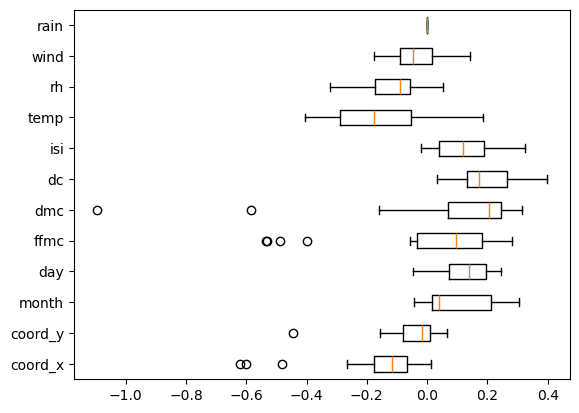

In [651]:
import matplotlib.pyplot as plt
bp = plt.boxplot(importances_dt, vert = False,  labels = importances_dt.columns)

In [652]:
pd.concat(
    [
        pd.Series(pi_res.importances_mean, index = X_test.columns, name = 'Mean Importance'),
        pd.Series(pi_res.importances_std, index = X_test.columns, name = "Std Importance")
    ], 
    axis = 1).sort_values("Mean Importance", ascending  = False)

,Mean Importance,Std Importance
dc,0.193546,0.097410
day,0.127792,0.079145
isi,0.116248,0.083639
dmc,0.092889,0.282934
month,0.091381,0.112647
ffmc,0.024803,0.223684
rain,0.000000,0.000000
wind,-0.038107,0.080835
coord_y,-0.043853,0.092984
rh,-0.112567,0.092182


Based on waterfall, beeswarm and boxplot readings, we can conclude : 

High Importance :

1. The features of High Importance are FFMC, DMC, Temperature, wind, DC, RH  are of relatively high importance.

Moderate Importance :

2. Rain, Coordinates X and Coordinates Y is moderately important.


Least Importance :

3. Day and Month has relative least importance and can be removed as per waterfall, beeswarm and boxplot.

Correlation :

4. Wind + Temperature and Coodinate X + Temp are slightly coorelated.
5. Wind and ISI are highlly correalted.

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.